## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline

# Visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

## Read Dataset

- Location of tasks
  - are specified by **latitude** and **longitude** together.
- **day**, **hour** and **minute** describe the task publish time.
- **Duration** denotes task active duration in terms of minutes.
- **Remaining time** denotes the residual time of a sensing task till its completion.
- **Resources** is percentage of battery required to complete a task.
- **Coverage** denotes task sensing distance.
- **Legitimacy** describes whether a task is illegitimate one or legitimate one.

### This features is used only in training of the machine learning models as the MCS platform is unaware of task legitimacy when a task is submitted.

- **GridNumber** is obtained by splitting sensing city map to small grids with numbers beginning at 1. 
- **OnpeakHour** is a binary flag to indicate if task start time occurs during 7am to 11am.
  - We define 7am to 11am as the **peak hour (1)**
  - and other hours are **non-peak (0)**

In [2]:
df = pd.read_csv("MCSDatasetNEXTCONLab.csv")
df.head()

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
0,1,45.442142,-75.303369,1,4,13,40,40,9,91,0,131380,1
1,1,45.442154,-75.304366,1,4,23,40,30,9,91,0,131380,1
2,1,45.442104,-75.303963,1,4,33,40,20,9,91,0,121996,1
3,1,45.441868,-75.303577,1,4,43,40,10,9,91,0,121996,1
4,2,45.447727,-75.147722,2,15,49,30,30,5,47,0,140784,1


## Info about data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14484 non-null  int64  
 1   Latitude       14484 non-null  float64
 2   Longitude      14484 non-null  float64
 3   Day            14484 non-null  int64  
 4   Hour           14484 non-null  int64  
 5   Minute         14484 non-null  int64  
 6   Duration       14484 non-null  int64  
 7   RemainingTime  14484 non-null  int64  
 8   Resources      14484 non-null  int64  
 9   Coverage       14484 non-null  int64  
 10  OnPeakHours    14484 non-null  int64  
 11  GridNumber     14484 non-null  int64  
 12  Ligitimacy     14484 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 1.4 MB


In [4]:
df.describe()

,ID,Latitude,Longitude,Day,Hour,Minute,Duration,RemainingTime,Resources,Coverage,OnPeakHours,GridNumber,Ligitimacy
count,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000
mean,2009.362745,45.484035,-75.217603,2.513946,12.348177,29.480185,44.219829,27.109914,5.838097,65.292184,0.182822,199039.373239,0.869028
std,1164.521555,0.058989,0.054501,1.704509,6.538839,17.353324,14.511027,14.993890,2.878052,20.311306,0.386534,101695.208646,0.337381
min,1.000000,45.365600,-75.334116,0.000000,0.000000,0.000000,10.000000,10.000000,1.000000,30.000000,0.000000,-9363.000000,0.000000
25%,989.000000,45.434521,-75.264506,1.000000,7.000000,14.000000,30.000000,10.000000,3.000000,48.000000,0.000000,112621.000000,1.000000
50%,2025.000000,45.484917,-75.220013,2.000000,13.000000,29.000000,50.000000,20.000000,6.000000,65.000000,0.000000,197082.000000,1.000000
75%,3011.000000,45.541527,-75.173048,4.000000,18.000000,45.000000,60.000000,40.000000,8.000000,82.000000,0.000000,300297.000000,1.000000
max,4000.000000,45.584678,-75.088915,6.000000,23.000000,59.000000,60.000000,60.000000,10.000000,100.000000,1.000000,375388.000000,1.000000


#### Check null values

In [5]:
df.isnull().sum().sum()

0

#### Check duplicate

In [6]:
df.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
         ...  
14479    False
14480    False
14481    False
14482    False
14483    False
Length: 14484, dtype: bool

In [7]:
df['Ligitimacy'].unique()

array([1, 0], dtype=int64)

#### Replace 0 with -1

In [3]:
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
df['Ligitimacy'].unique()

array([ 1, -1])

#### Split dataset to train and test

In [4]:
trDf = df[:10139][:]
teDf = df[10139:][:]

trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)

y_train = trDf['Ligitimacy'].values
y_test = teDf['Ligitimacy'].values

X_train = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
X_test = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [10]:
X_train.shape

(10139, 10)

### Heatmap

<AxesSubplot:>

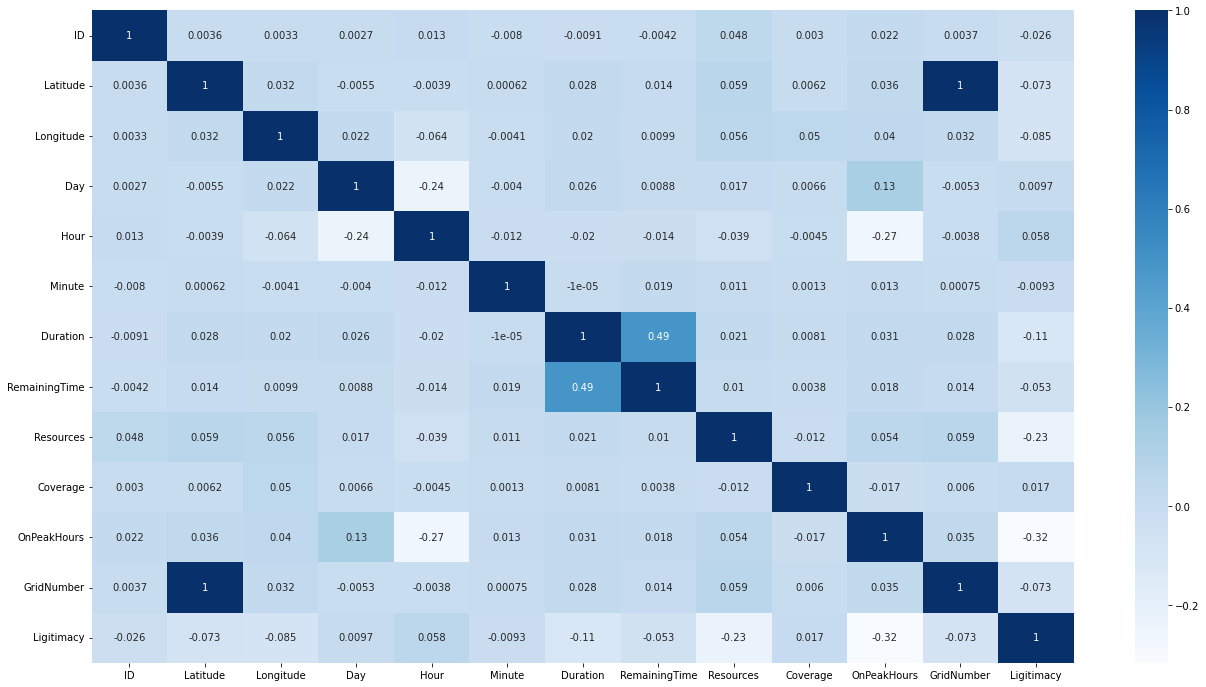

In [11]:
plt.figure(figsize=(22,12))
sns.heatmap(trDf.corr(), annot=True,  cmap= "Blues")

### Scatter Plot Matrix

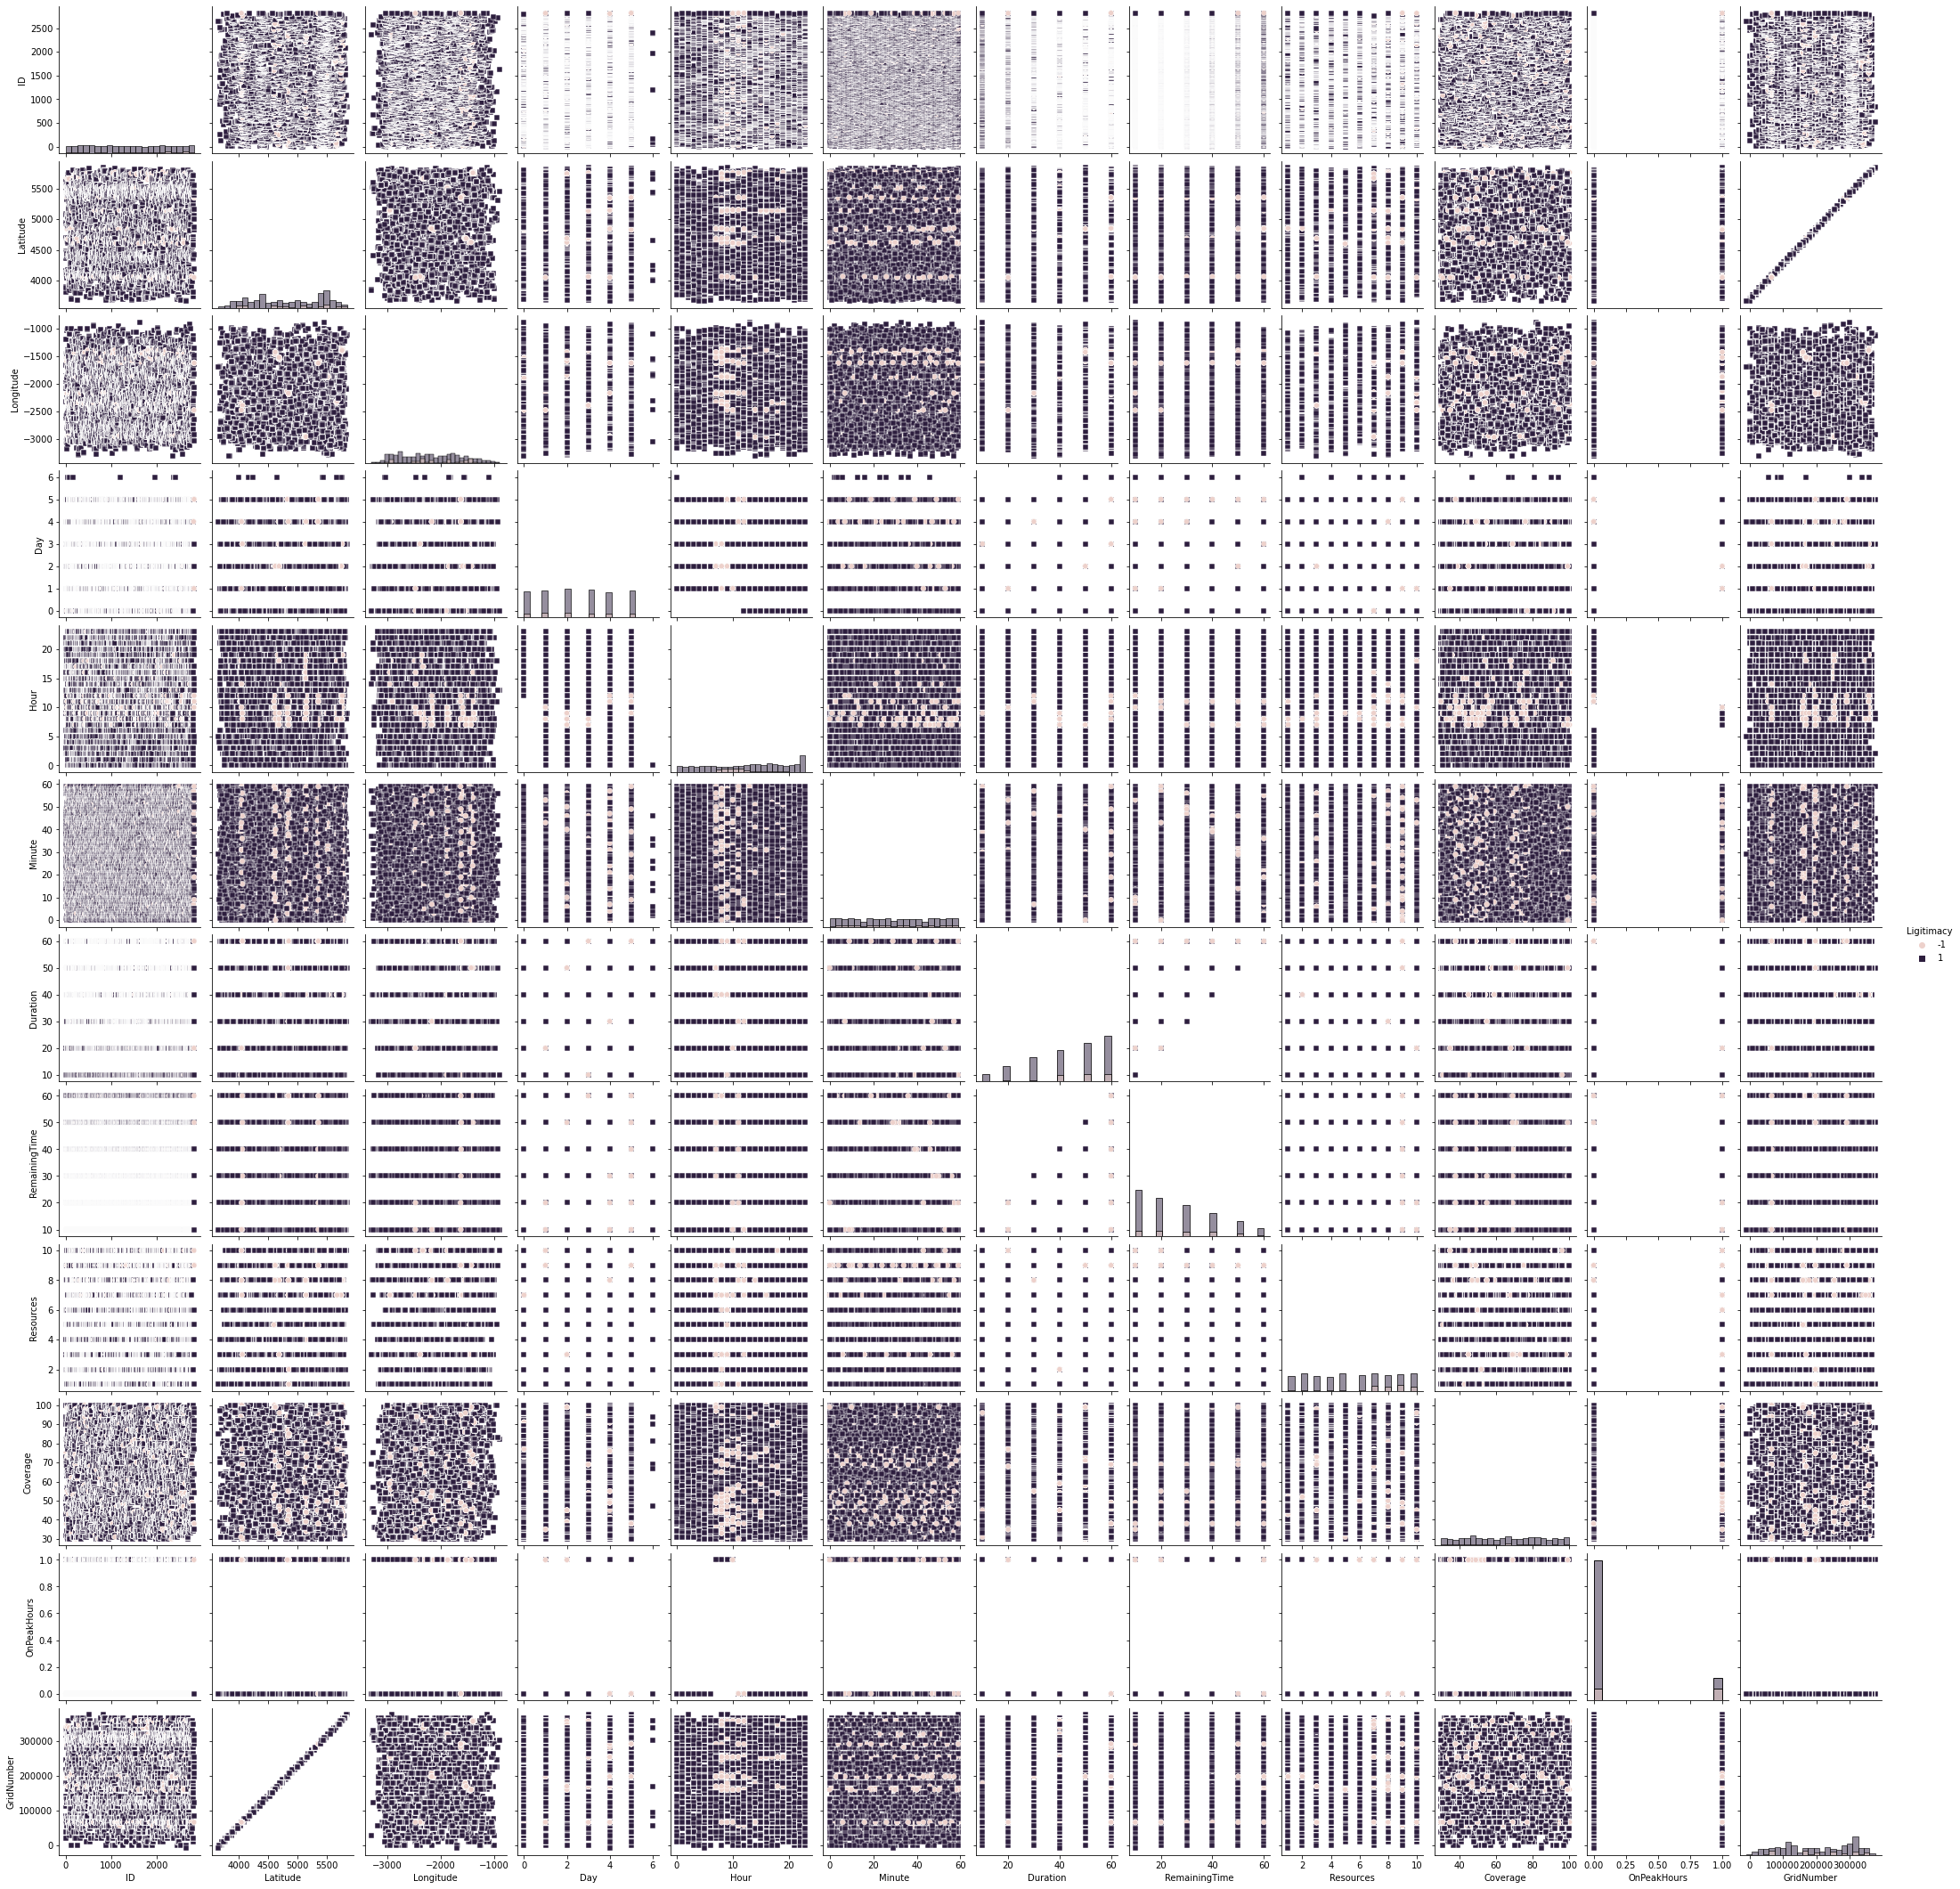

In [12]:
sns.pairplot(trDf, hue='Ligitimacy', diag_kind="hist", markers=["o", "s"])  
plt.show()

- From Scatter plot matrix and heatmap, we see that this a high positive correlation between **latitude** and **GridNumber**

### Visualize data

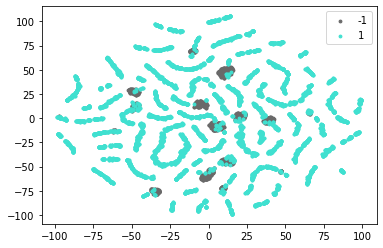

In [13]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train)
color = ['dimgrey', 'turquoise']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train == label, 0], tr2d[y_train == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

# Part 1 

# Q1

### Method to print model accuracy

In [5]:
def print_accuracy(model, y_test, y_pred, X_test):
    
    print('\nClassification Report:\n')
    print(classification_report(y_test, y_pred))
    print("---------------------------------------------\n")

    acc = accuracy_score(y_test, y_pred) 
    print("Accuracy: {:.2f}\n".format(acc))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    print('\nConfusion Matrix:')
    plot_confusion_matrix(model, X_test, y_test,
                          xticks_rotation='horizontal',
                          ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()
    
    return acc 

### Method to build models

In [6]:
def build_model(estimator_obj, X_train, X_test, y_train, y_test):

    model = estimator_obj.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_acc = print_accuracy(model, y_test, y_pred, X_test)
    
    return model, y_pred, round(model_acc,3)

### 1- KNN


Classification Report:

              precision    recall  f1-score   support

          -1       0.88      0.99      0.93       597
           1       1.00      0.98      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.94      0.98      0.96      4345
weighted avg       0.98      0.98      0.98      4345

---------------------------------------------

Accuracy: 0.98


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


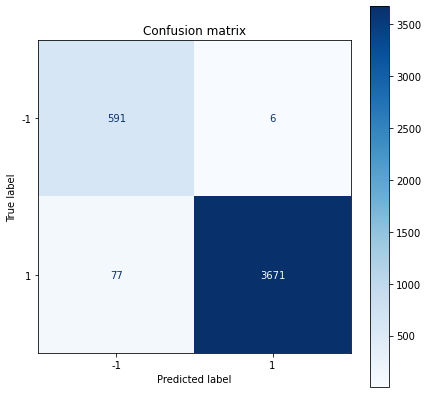

In [7]:
knn = KNeighborsClassifier(algorithm= 'brute')
knn_model, knn_pred, knn_acc = build_model(knn, X_train, X_test, y_train, y_test)

### 2- LogisticRegression


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

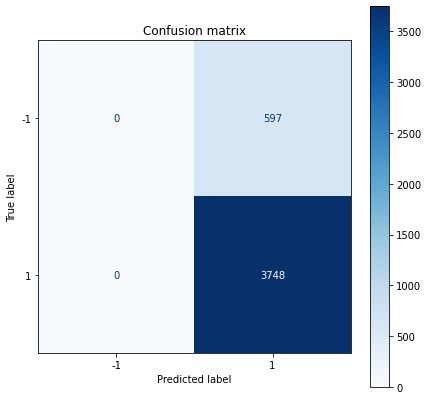

In [8]:
lr = LogisticRegression()
lr_model, lr_pred, lr_acc = build_model(lr, X_train, X_test, y_train, y_test)

### 3- SVM


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

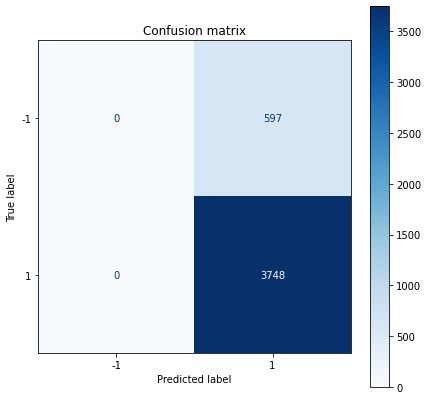

In [9]:
svm = SVC(kernel= 'rbf')
svm_model, svm_pred, svm_acc = build_model(svm, X_train, X_test, y_train, y_test)

### 4- Decision Tree


Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.78      0.82       597
           1       0.97      0.98      0.97      3748

    accuracy                           0.95      4345
   macro avg       0.92      0.88      0.90      4345
weighted avg       0.95      0.95      0.95      4345

---------------------------------------------

Accuracy: 0.95


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


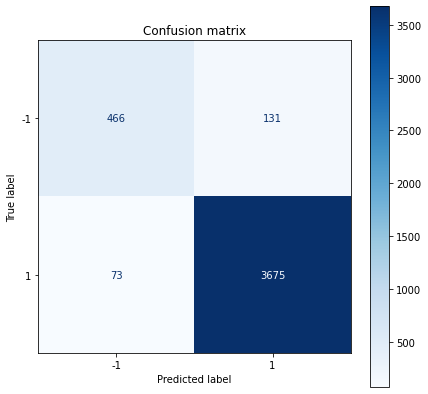

In [10]:
dt = DecisionTreeClassifier(criterion= 'entropy')
dt_model, dt_pred, dt_acc = build_model(dt, X_train, X_test, y_train, y_test)

### 5- AdaBoost


Classification Report:

              precision    recall  f1-score   support

          -1       0.93      0.85      0.89       597
           1       0.98      0.99      0.98      3748

    accuracy                           0.97      4345
   macro avg       0.95      0.92      0.94      4345
weighted avg       0.97      0.97      0.97      4345

---------------------------------------------

Accuracy: 0.97


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


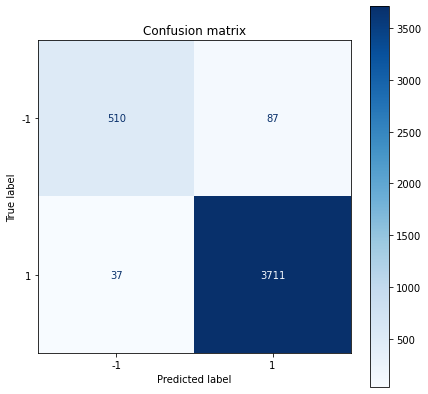

In [11]:
ada = AdaBoostClassifier(n_estimators=150, random_state=0)
ada_model, ada_pred, ada_acc = build_model(ada, X_train, X_test, y_train, y_test)

### plot models in a bar-chart as baseline

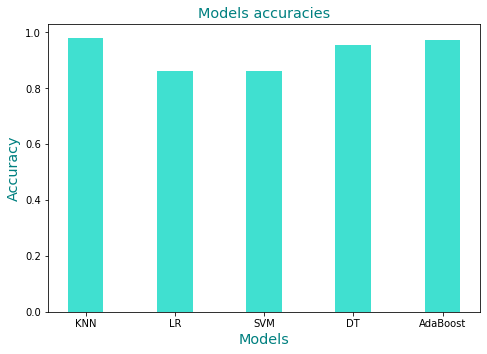

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['KNN', 'LR', 'SVM', 'DT', 'AdaBoost']
acc = [knn_acc,lr_acc,svm_acc,dt_acc,ada_acc]
ax.bar(models,acc, color= 'turquoise', width=0.4)
ax.yaxis
plt.xlabel('Models', fontsize = 'x-large',  color = 'teal')
plt.ylabel('Accuracy', fontsize = 'x-large',color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.show()

# Q2

## 1- SMOTE

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
oversample = SMOTE(random_state=0)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

### 1- KNN


Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.99      0.92       597
           1       1.00      0.98      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.93      0.98      0.96      4345
weighted avg       0.98      0.98      0.98      4345

---------------------------------------------

Accuracy: 0.98


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


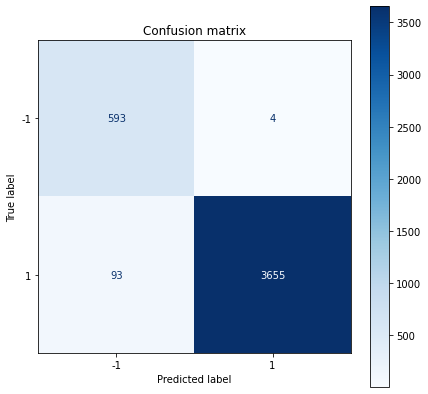

In [15]:
knn_model_smote, knn_pred_smote, knn_acc_smote = build_model(knn, X_train_smote, X_test, y_train_smote, y_test)

### 2- Decision Tree


Classification Report:

              precision    recall  f1-score   support

          -1       0.84      0.78      0.81       597
           1       0.97      0.98      0.97      3748

    accuracy                           0.95      4345
   macro avg       0.90      0.88      0.89      4345
weighted avg       0.95      0.95      0.95      4345

---------------------------------------------

Accuracy: 0.95


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


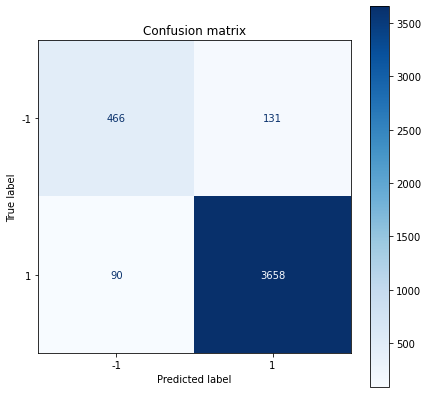

In [16]:
dt_model_smote, dt_pred_smote, dt_acc_smote = build_model(dt, X_train_smote, X_test, y_train_smote, y_test)

### 3- AdaBoost


Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.90      0.86       597
           1       0.98      0.97      0.98      3748

    accuracy                           0.96      4345
   macro avg       0.90      0.93      0.92      4345
weighted avg       0.96      0.96      0.96      4345

---------------------------------------------

Accuracy: 0.96


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


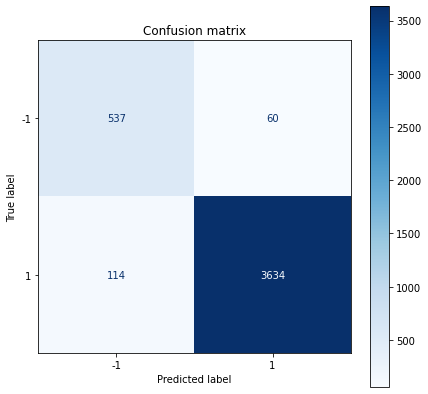

In [17]:
ada_model_smote, ada_pred_smote, ada_acc_smote = build_model(ada, X_train_smote, X_test, y_train_smote, y_test)

## 2- ADASYN

In [18]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state= 42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

### 1- KNN


Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.99      0.92       597
           1       1.00      0.98      0.99      3748

    accuracy                           0.98      4345
   macro avg       0.93      0.98      0.96      4345
weighted avg       0.98      0.98      0.98      4345

---------------------------------------------

Accuracy: 0.98


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


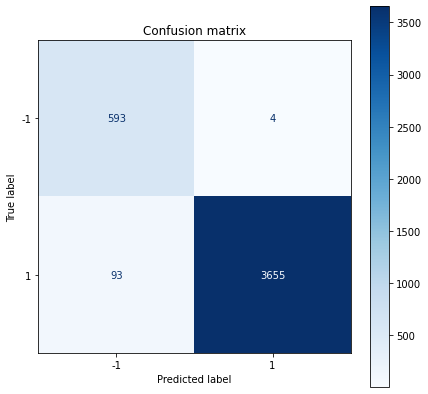

In [19]:
knn_model_adasyn, knn_pred_adasyn, knn_acc_adasyn = build_model(knn,
                                                                X_train_adasyn,
                                                                X_test,
                                                                y_train_adasyn,
                                                                y_test)

### 2- Decision Tree


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.77      0.79       597
           1       0.96      0.97      0.97      3748

    accuracy                           0.94      4345
   macro avg       0.89      0.87      0.88      4345
weighted avg       0.94      0.94      0.94      4345

---------------------------------------------

Accuracy: 0.94


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


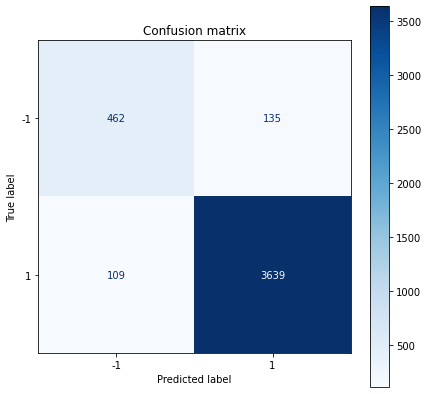

In [20]:
dt_model_adasyn, dt_pred_adasyn, dt_acc_adasyn = build_model(dt, 
                                                             X_train_adasyn,
                                                             X_test,
                                                             y_train_adasyn,
                                                             y_test)

### 3- AdaBoost


Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.88      0.85       597
           1       0.98      0.97      0.98      3748

    accuracy                           0.96      4345
   macro avg       0.90      0.92      0.91      4345
weighted avg       0.96      0.96      0.96      4345

---------------------------------------------

Accuracy: 0.96


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


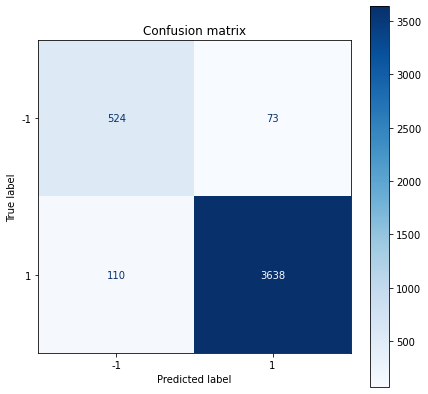

In [21]:
ada_model_adasyn, ada_pred_adasyn, ada_acc_adasyn = build_model(ada,
                                                                X_train_adasyn,
                                                                X_test,
                                                                y_train_adasyn,
                                                                y_test)

## 3- Random Undersampling

In [22]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampling = RandomUnderSampler(random_state= 42)
X_train_random, y_train_random = random_under_sampling.fit_resample(X_train, y_train)

### 1- KNN


Classification Report:

              precision    recall  f1-score   support

          -1       0.76      1.00      0.86       597
           1       1.00      0.95      0.97      3748

    accuracy                           0.96      4345
   macro avg       0.88      0.97      0.92      4345
weighted avg       0.97      0.96      0.96      4345

---------------------------------------------

Accuracy: 0.96


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


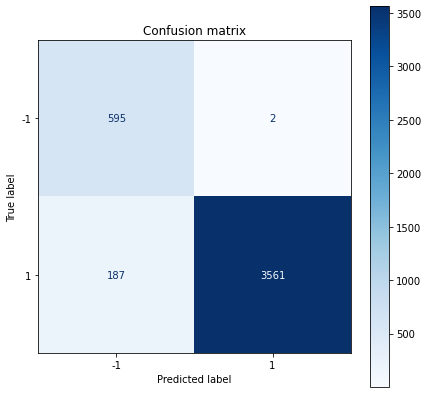

In [23]:
knn_model_random, knn_pred_random, knn_acc_random = build_model(knn,
                                                                X_train_random,
                                                                X_test,
                                                                y_train_random,
                                                                y_test)

### 2- decision Tree


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.82      0.71       597
           1       0.97      0.92      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.80      0.87      0.83      4345
weighted avg       0.92      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


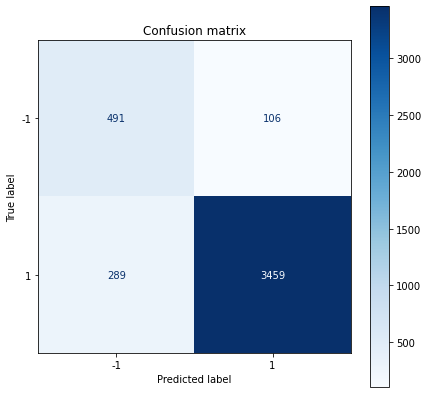

In [24]:
dt_model_random, dt_pred_random, dt_acc_random = build_model(dt, 
                                                             X_train_random,
                                                             X_test,
                                                             y_train_random,
                                                             y_test)

### 3- AdaBoost


Classification Report:

              precision    recall  f1-score   support

          -1       0.76      0.95      0.85       597
           1       0.99      0.95      0.97      3748

    accuracy                           0.95      4345
   macro avg       0.88      0.95      0.91      4345
weighted avg       0.96      0.95      0.95      4345

---------------------------------------------

Accuracy: 0.95


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


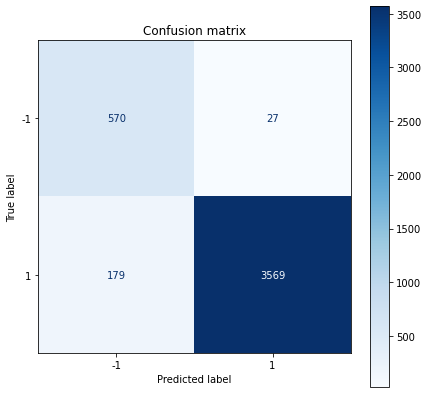

In [25]:
ada_model_random, ada_pred_random, ada_acc_random = build_model(ada,
                                                                X_train_random,
                                                                X_test,
                                                                y_train_random,
                                                                y_test)

In [26]:
print("knn_acc_smote", knn_acc_smote)
print("knn_acc_adasyn", knn_acc_adasyn)
print("knn_acc_random", knn_acc_random)
print()
print("dt_acc_smote", dt_acc_smote)
print("dt_acc_adasyn", dt_acc_adasyn)
print("dt_acc_random", dt_acc_random)
print()
print("ada_acc_smote", ada_acc_smote)
print("ada_acc_adasyn", ada_acc_adasyn)
print("ada_acc_random", ada_acc_random)

knn_acc_smote 0.978
knn_acc_adasyn 0.978
knn_acc_random 0.957

dt_acc_smote 0.949
dt_acc_adasyn 0.944
dt_acc_random 0.909

ada_acc_smote 0.96
ada_acc_adasyn 0.958
ada_acc_random 0.953


#### Highest accuracy with methods

In [27]:
highest_acc_smote = [knn_acc_smote, dt_acc_smote, ada_acc_smote]

#### store accuracy of each method with the selected models

In [28]:
smote_accs = [knn_acc_smote, dt_acc_smote, ada_acc_smote]
adasyn_accs= [knn_acc_adasyn, dt_acc_adasyn, ada_acc_adasyn]
random_accs= [knn_acc_random, dt_acc_random, ada_acc_random]
baseline_accs= [knn_acc, dt_acc, ada_acc]

accs = [baseline_accs, smote_accs, adasyn_accs, random_accs]
models = ['KNN', "Decision Tree", "AdaBoost"]

### Method to plot accuracy vs over / under sampling

In [29]:
def accuracy_with_over_under_sampling(x_values, y_values):
    
    plt.figure(figsize=(8,6))

    axis_1 = plt.plot(x_values, y_values[0], color='cyan', marker='o', 
                     linestyle='dashdot', label = 'Baseline')
    axis_2 = plt.plot(x_values, y_values[1], color='lightseagreen', marker='o',
                     linestyle='dashdot', label = 'Smote')
    axis_3 = plt.plot(x_values, y_values[2], color='dimgrey', marker='o',
                     linestyle='dashdot', label = 'Adasyn')
    axis_4 = plt.plot(x_values, y_values[3], color='steelblue', marker='o',
                     linestyle='dashdot', label = 'Random Undersampling')
    
    plt.xlabel('Models', fontsize = 15,  color = 'teal')
    plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
    plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show

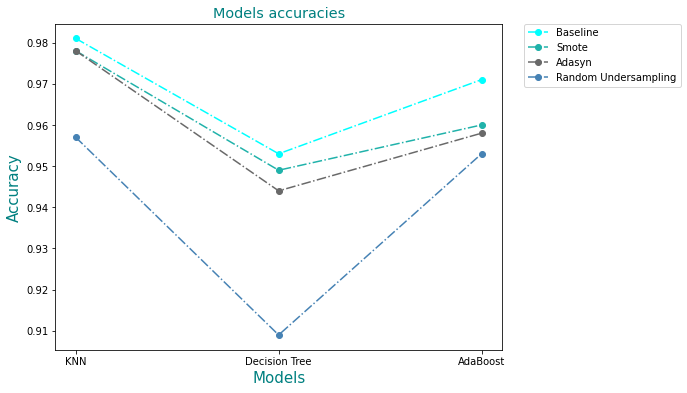

In [30]:
accuracy_with_over_under_sampling(models, accs)

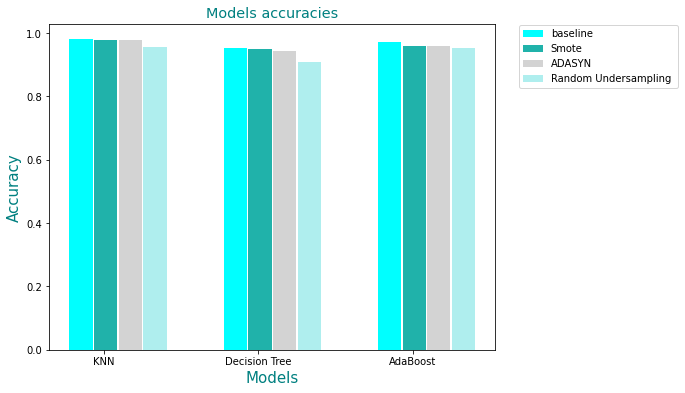

In [31]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 6))
 
# Set position of bar on X axis
X = np.arange(3)
br1 = X + 0.00
br2 = X + 0.16
br3 = X + 0.32
br4 = X + 0.48
 
# Make the plot
plt.bar(br1, baseline_accs, color ='cyan', width = barWidth,
         label ='baseline')
plt.bar(br2, highest_acc_smote, color ='lightseagreen', width = barWidth,
        label ='Smote')
plt.bar(br3, adasyn_accs, color ='lightgrey', width = barWidth,
         label ='ADASYN')
plt.bar(br4, random_accs, color ='paleturquoise', width = barWidth,
         label ='Random Undersampling ')
 
# Adding Xticks
plt.xlabel('Models', fontsize = 15,  color = 'teal')
plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.xticks([r + barWidth for r in range(len(baseline_accs))],models)
 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

### bar chart to show the changes in performance

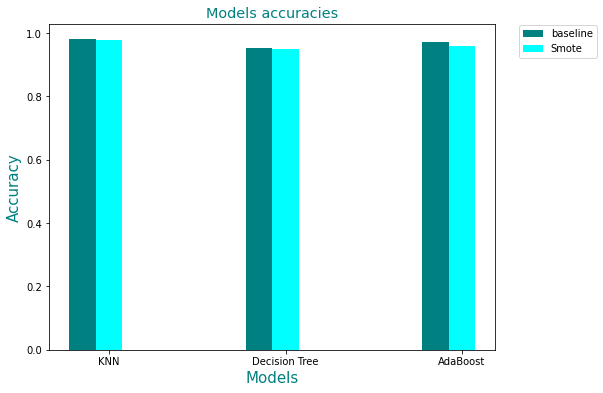

In [32]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 6))
 
# set height of bar
highest_acc_smote
baseline_accs
 
# Set position of bar on X axis
br1 = np.arange(len(baseline_accs))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, baseline_accs, color ='teal', width = barWidth,
        label ='baseline')
plt.bar(br2, highest_acc_smote, color ='cyan', width = barWidth,
      label ='Smote')

 
# Adding Xticks
plt.xlabel('Models', fontsize = 15,  color = 'teal')
plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.xticks([r + barWidth for r in range(len(baseline_accs))],models)
 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

# Question 3  
## Feature Selection & Dimensionality Reduction  
# 1- RFE

In [33]:
def Accuracies(model, estimator, X_train, y_train, X_test, y_test):
    acc_list = []
    for i in range(3, 11):
        estimator = DecisionTreeClassifier()
        selector = RFE(estimator, n_features_to_select = i)#, step = 1)
        selector = selector.fit(X_train, y_train)
        r = selector.ranking_
        features = np.where(r != 1)
        new_x_train = np.delete(X_train, features, 1)
        new_x_test = np.delete(X_test, features, 1)
        model = model.fit(new_x_train, y_train)
        y_pred = model.predict(new_x_test) 
        acc = accuracy_score(y_test, y_pred) 
        acc_list.append(round(acc,3))
    return acc_list

In [34]:
#Method to plot accuracies
def plot_acc(model_acc):
    plt.plot([3, 4, 5, 6, 7, 8, 9, 10], model_acc,  marker='o', label='line with marker', color = 'teal')
    plt.xlabel('Number of features', fontsize = 15,  color = 'teal')
    plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
    plt.title('RFE Reduced data', fontsize = 'x-large', color = 'teal')

### Applying RFE as a preprocessing on data with highest accuracy (Smote)

In [35]:
knn_acc_smote = Accuracies(knn, DecisionTreeClassifier(), X_train_smote, y_train_smote, X_test, y_test)
dt_acc_smote = Accuracies(dt, DecisionTreeClassifier(), X_train_smote, y_train_smote, X_test, y_test)
ada_acc_smote = Accuracies(ada, DecisionTreeClassifier(), X_train_smote, y_train_smote, X_test, y_test)

In [36]:
knn_acc_smote

[0.978, 0.982, 0.983, 0.984, 0.98, 0.98, 0.979, 0.978]

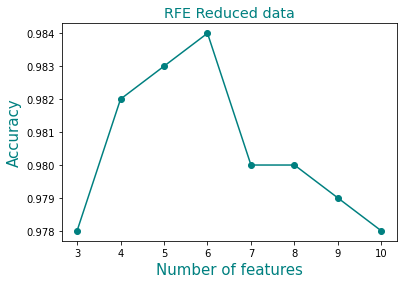

In [37]:
plot_acc(knn_acc_smote)   # 6

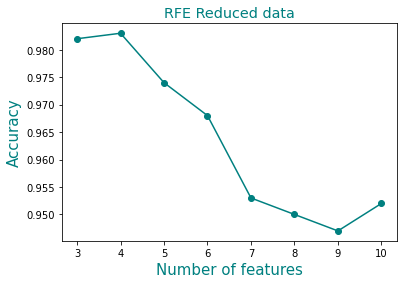

In [38]:
plot_acc(dt_acc_smote)   #3

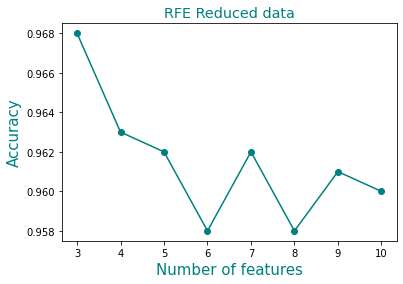

In [39]:
plot_acc(ada_acc_smote)   #3

In [40]:
RFE_Acc_smote = [max(knn_acc_smote), max(dt_acc_smote), max(ada_acc_smote)]

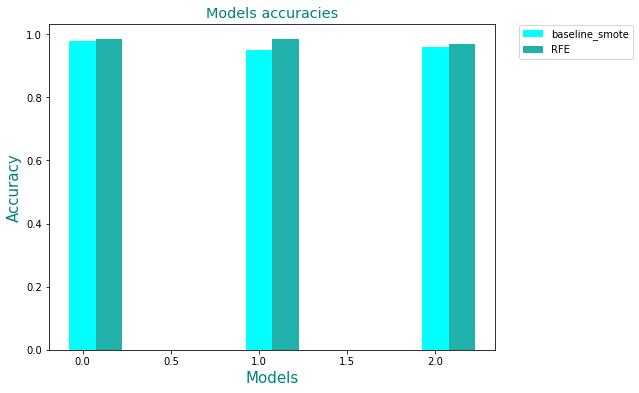

In [41]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 6))

# Make the plot
plt.bar(br1, highest_acc_smote, color ='cyan', width = barWidth,
         label ='baseline_smote')
plt.bar(br2, RFE_Acc_smote, color ='lightseagreen', width = barWidth,
        label ='RFE')

# Adding Xticks
plt.xlabel('Models', fontsize = 15,  color = 'teal')
plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

### Applying RFE as a preprocessing on data with Adasyn

In [42]:
knn_acc_adasyn = Accuracies(knn, DecisionTreeClassifier(), X_train_adasyn, y_train_adasyn, X_test, y_test)
dt_acc_adasyn = Accuracies(dt, DecisionTreeClassifier(), X_train_adasyn, y_train_adasyn, X_test, y_test)
ada_acc_adasyn= Accuracies(ada, DecisionTreeClassifier(), X_train_adasyn, y_train_adasyn, X_test, y_test)

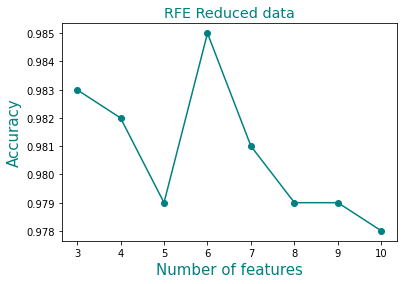

In [43]:
plot_acc(knn_acc_adasyn)

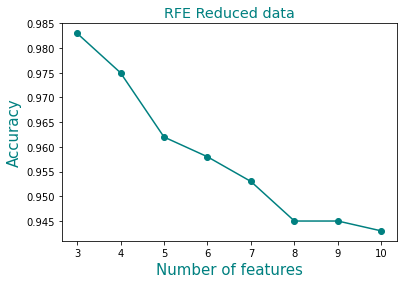

In [44]:
plot_acc(dt_acc_adasyn)

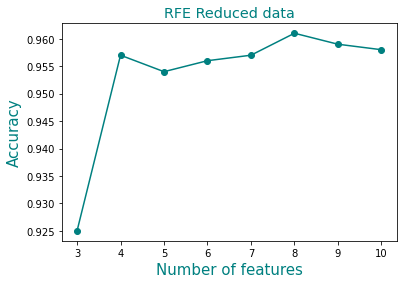

In [45]:
plot_acc(ada_acc_adasyn)

In [46]:
RFE_Acc_adasyn = [max(knn_acc_adasyn), max(dt_acc_adasyn), max(ada_acc_adasyn)]

### Applying RFE as a preprocessing on data with Random Undersampling

In [47]:
knn_acc_random = Accuracies(knn, DecisionTreeClassifier(), X_train_random, y_train_random, X_test, y_test)
dt_acc_random = Accuracies(dt, DecisionTreeClassifier(), X_train_random, y_train_random, X_test, y_test)
ada_acc_random= Accuracies(ada, DecisionTreeClassifier(), X_train_random, y_train_random, X_test, y_test)


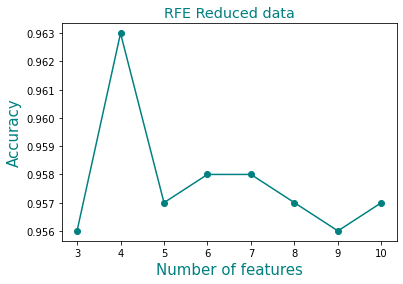

In [48]:
plot_acc(knn_acc_random)

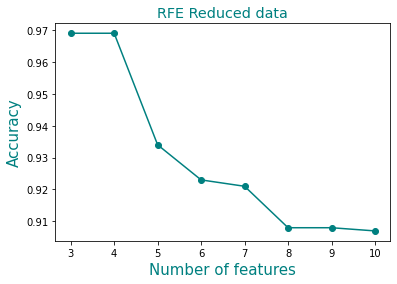

In [49]:
plot_acc(dt_acc_random)

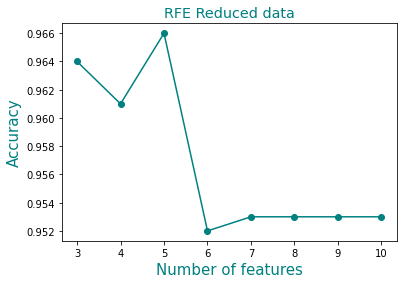

In [50]:
plot_acc(ada_acc_random)

In [51]:
RFE_Acc_random = [max(knn_acc_random), max(dt_acc_random), max(ada_acc_random)]

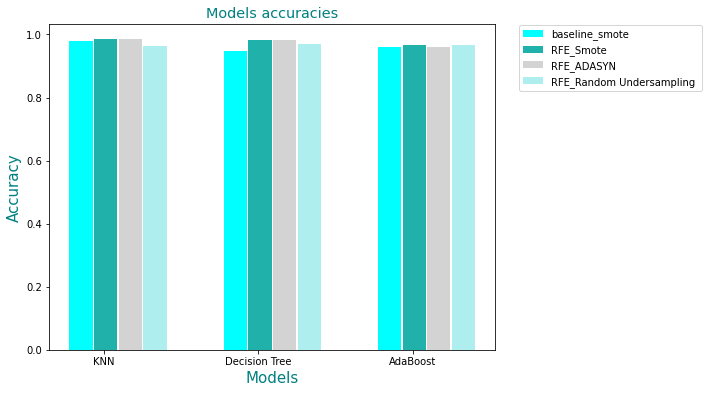

In [52]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 6))

# Set position of bar on X axis
X = np.arange(3)
br1 = X + 0.00
br2 = X + 0.16
br3 = X + 0.32

# Make the plot
plt.bar(br1, highest_acc_smote, color ='cyan', width = barWidth,
         label ='baseline_smote')
plt.bar(br2, RFE_Acc_smote, color ='lightseagreen', width = barWidth,
        label ='RFE_Smote')
plt.bar(br3, RFE_Acc_adasyn, color ='lightgrey', width = barWidth,
         label ='RFE_ADASYN')
plt.bar(br4, RFE_Acc_random, color ='paleturquoise', width = barWidth,
         label ='RFE_Random Undersampling ')

# Adding Xticks
plt.xlabel('Models', fontsize = 15,  color = 'teal')
plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.xticks([r + barWidth for r in range(len(baseline_accs))],models)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

# T-SNE

## T-SNE on the original data Before Over/Under Sampling

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


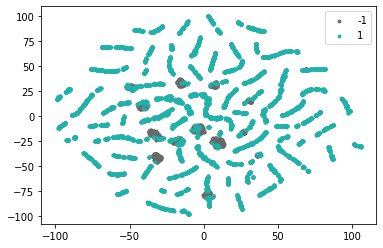

In [53]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train)
color = ['dimgrey', 'lightseagreen']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train == label, 0], tr2d[y_train == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

## T-SNE before the Feature Selection on the data with the highest accuracy "SMOTE"

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


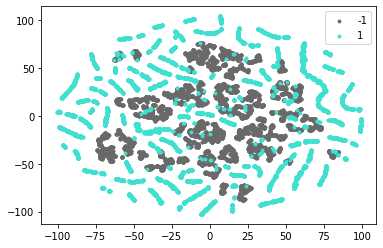

In [54]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train_smote)
color = ['dimgrey', 'turquoise']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

## Selected features

In [55]:
# function to return selected features
def selected_features(model, X_train, y_train, X_test, y_test):
    if (model == knn):
        features = 6
    elif (model == dt):
        features = 3
    else:
        features = 4
    estimator = DecisionTreeClassifier()
    selector = RFE(estimator, n_features_to_select = features)
    selector = selector.fit(X_train, y_train)
    r = selector.ranking_
    features = np.where(r != 1)
    new_x_train = np.delete(X_train, features, 1)
    return new_x_train

In [56]:
knn_selected = selected_features(knn, X_train_smote, y_train_smote, X_test, y_test)

In [57]:
dt_selected = selected_features(dt, X_train_smote, y_train_smote, X_test, y_test)

In [58]:
ada_selected = selected_features(ada, X_train_smote, y_train_smote, X_test, y_test)

## T-SNE after feature Selection with RFE on oversampled data with Smote

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


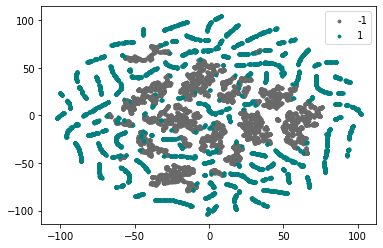

In [59]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(knn_selected)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


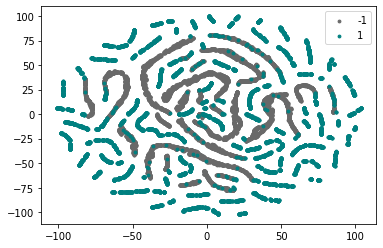

In [60]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(dt_selected)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


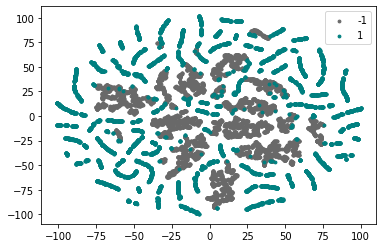

In [61]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(ada_selected)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

#  Stacking

## Using stacking on the higher number of features (6) from RFE

>knn 0.995 (0.002)
>DT 0.994 (0.002)
>ada 0.945 (0.005)
>stacking 0.997 (0.002)


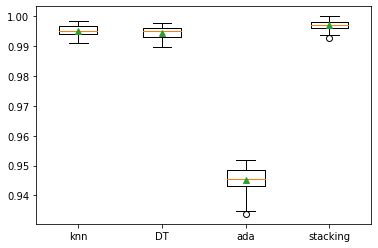

In [62]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    return X, y

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('DT', DecisionTreeClassifier()))
    level0.append(('Ada', AdaBoostClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['DT'] = DecisionTreeClassifier()
    models['ada'] = AdaBoostClassifier()
    models['stacking'] = get_stacking()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X, y = knn_selected, y_train_smote
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [84]:
baseline = max(baseline_accs)
smote = max(highest_acc_smote)
RFE = max(RFE_Acc_smote)
stack = round(max(results[3]),3)

In [88]:
# baseline = baseline*100
# smote = smote * 100
# RFE = RFE * 100
# stack = stack *100
baseline = baseline * 100

In [90]:
smote = smote * 100

In [92]:
RFE = RFE * 100

In [95]:
stack = stack * 100

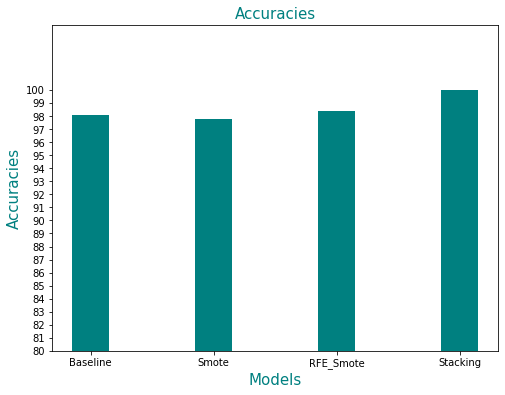

In [96]:
width =0.3 
plt.subplots(figsize=(8, 6))
plt.bar(['Baseline', 'Smote', 'RFE_Smote', 'Stacking'],
        [baseline,smote,RFE ,stack],
        width= width,
        color ='teal')
plt.title('Accuracies', fontsize = 15, color = 'teal')
plt.ylabel('Accuracies', fontsize = 15, color = 'teal')
plt.xlabel('Models', fontsize = 15, color = 'teal')
plt.yticks(np.arange(80, 101, 1))
plt.ylim(ymin = 80)
plt.show()

# PCA 

In [65]:
#Method to plot accuracies
def plot_acc_pca(model_acc):
    plt.plot([3, 4, 5, 6, 7, 8, 9, 10], model_acc,  marker='o', label='line with marker', color = 'cyan')
    plt.xlabel('Number of features', fontsize = 15,  color = 'teal')
    plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
    plt.title('PCA Reduced data', fontsize = 'x-large', color = 'teal')

In [105]:
def build_model_pca(X_train, X_test, y_train, y_test, model):
    num_features = [ ] 
    acc_list = [ ] 
    for i in range(3, 11): 
        pca = PCA(n_components= i, svd_solver= 'full', random_state= 2021) 
        pca.fit(X_train, y_train) 
        pca_train = pca.transform(X_train)
        pca_test = pca.transform(X_test) 
        num_features.append(i)  
        model_pca = model.fit(pca_train, y_train) 
        y_pred = model_pca.predict(pca_test) 
        acc = accuracy_score(y_test, y_pred) * 100 
        acc_list.append(round(acc,3))     
    
    max_acc = np.max(acc_list)
    max_index = acc_list.index(max_acc)
    return (acc_list)

In [106]:
pca_smote_knn = build_model_pca( X_train_smote, X_test, y_train_smote, y_test, knn)

In [107]:
pca_smote_dt = build_model_pca(X_train_smote, X_test, y_train_smote, y_test, dt)

In [108]:
pca_smote_ada = build_model_pca(X_train_smote, X_test, y_train_smote, y_test, ada)

# PCA on previous highest accuracy (Smote)

In [109]:
pca_smote_knn

[97.652, 97.606, 97.445, 97.814, 97.814, 97.745, 97.768, 97.768]

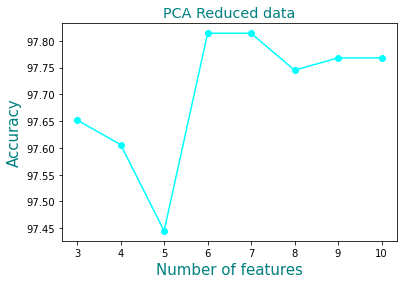

In [110]:
plot_acc_pca(pca_smote_knn)

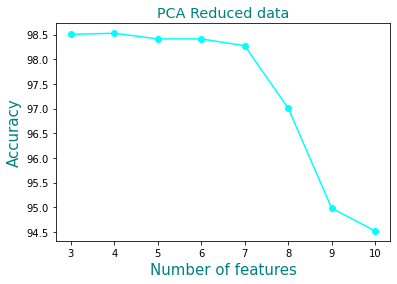

In [111]:
plot_acc_pca(pca_smote_dt)

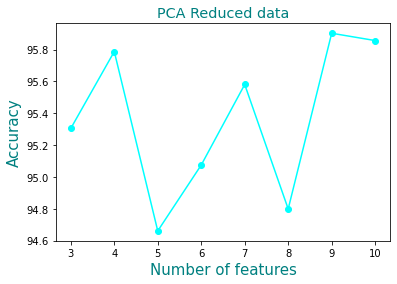

In [112]:
plot_acc_pca(pca_smote_ada)

In [113]:
PCA_Acc_smote = [max(pca_smote_knn), max(pca_smote_dt), max(pca_smote_ada)]

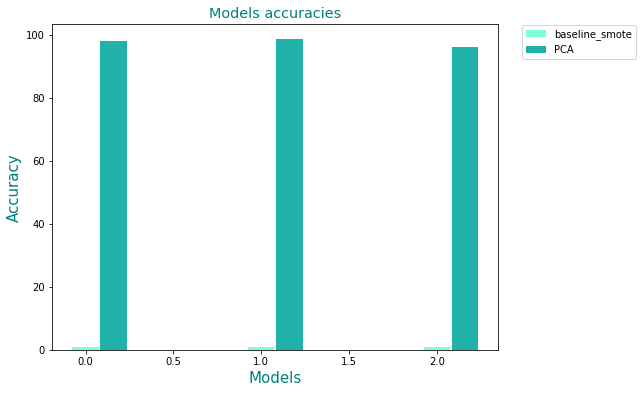

In [114]:
# set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 6))

# Make the plot
plt.bar(br1, highest_acc_smote, color ='aquamarine', width = barWidth,
         label ='baseline_smote')
plt.bar(br2, PCA_Acc_smote, color ='lightseagreen', width = barWidth,
        label ='PCA')
# Adding Xticks
plt.xlabel('Models', fontsize = 15,  color = 'teal')
plt.ylabel('Accuracy', fontsize = 15,color = 'teal' )
plt.title('Models accuracies', fontsize = 'x-large', color = 'teal')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

## Selecting features with PCA

In [115]:
def selected_features_pca(model, X_train, X_test, y_train, y_test):
    if (model == knn):
        features = 6
    elif (model == dt):
        features = 3
    else:
        features = 9
    pca = PCA(n_components= features, svd_solver= 'full', random_state= 2021) 
    pca.fit(X_train, y_train) 
    pca_train = pca.transform(X_train)
    pca_test = pca.transform(X_test) 
    #model_pca = model.fit(pca_train, pca_test) 
    return pca_train

In [116]:
knn_selected_pca = selected_features_pca(knn, X_train_smote, X_test, y_train_smote, y_test)
dt_selected_pca = selected_features_pca(dt, X_train_smote, X_test, y_train_smote, y_test)
ada_selected_pca = selected_features_pca(ada, X_train_smote, X_test, y_train_smote, y_test)

## T-SNE after feature Selection with PCA on oversampled data with Smote

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


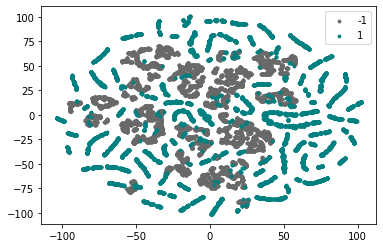

In [117]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(knn_selected_pca)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


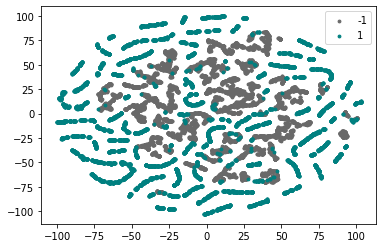

In [118]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(dt_selected_pca)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


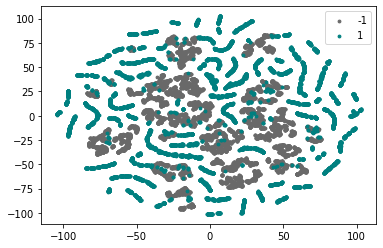

In [119]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(ada_selected_pca)
color = ['dimgrey', 'teal']
for index, label in enumerate(np.unique(y_train)):
    plt.scatter(tr2d[y_train_smote == label, 0], tr2d[y_train_smote == label, 1], s= 8, label=label, color = color[index])
plt.legend()
plt.show()

## Stacking On data reduced with PCA and over sampled with Smote 


Classification Report:

              precision    recall  f1-score   support

          -1       0.96      0.95      0.96       597
           1       0.99      0.99      0.99      3748

    accuracy                           0.99      4345
   macro avg       0.98      0.97      0.97      4345
weighted avg       0.99      0.99      0.99      4345

---------------------------------------------

Accuracy: 0.99


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


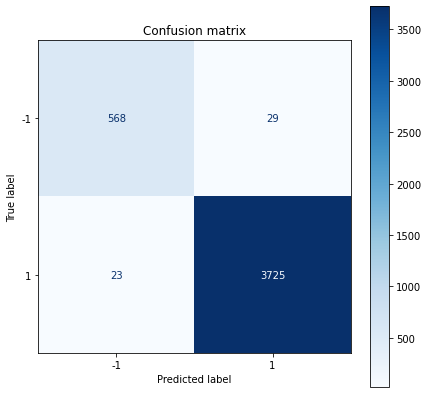

In [120]:
estimators = [('knn', make_pipeline(PCA(n_components = 6, random_state = 0 ),
                                    KNeighborsClassifier(n_neighbors = 3))),
              ('dt', make_pipeline(PCA(n_components = 3, random_state = 0 ),
                                    DecisionTreeClassifier(criterion = "entropy", random_state=0))),
              ('Ada', make_pipeline(PCA(n_components = 9, random_state = 0 ),
                                    AdaBoostClassifier(n_estimators=200, random_state=0)))]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
knn_model, stack_pred, stack_acc = build_model(stacking_clf, X_train_smote, X_test, y_train_smote, y_test)

In [121]:
PCA_Acc_smote = [max(pca_smote_knn), max(pca_smote_dt), max(pca_smote_ada)]
max(PCA_Acc_smote)

98.527

In [122]:
baseline = max(baseline_accs)
smote = max(highest_acc_smote)
RFE = max(PCA_Acc_smote)
stack = stack_acc

In [128]:
baseline1 = baseline * 100
smote1 = smote * 100
RFE1 = RFE 
stack1 = stack * 100

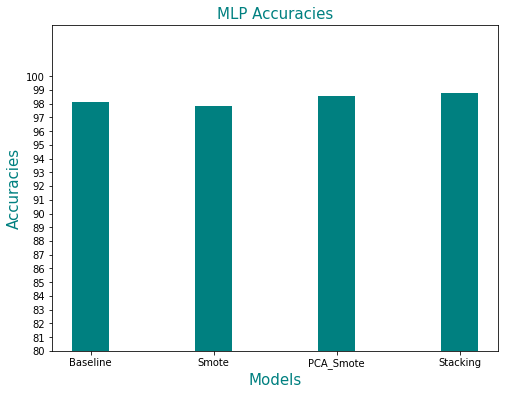

In [129]:
width =0.3 
plt.subplots(figsize=(8, 6))
plt.bar(['Baseline', 'Smote', 'PCA_Smote', 'Stacking'],
        [baseline1, smote1, RFE1, stack1],
        width= width,
        color ='teal')
plt.title('MLP Accuracies', fontsize = 15, color = 'teal')
plt.ylabel('Accuracies', fontsize = 15, color = 'teal')
plt.xlabel('Models', fontsize = 15, color = 'teal')
plt.yticks(np.arange(80, 101, 1))
plt.ylim(ymin = 80)
plt.show()